# Neural Network Surrogate Model for Metasurface Transmission Spectra

This notebook trains a neural network to predict complex transmission coefficients (t_xx) as a function of:
- Rectangle length (L)
- Rectangle width (W)  
- Wavelength (λ)

**Model Structure:**
- Input: (L, W, λ) - 3 features
- Output: (Re(t_xx), Im(t_xx)) - 2 features
- Architecture: MLP [256, 512, 512, 512, 256]
- Loss: MSE + Gradient Matching

In [2]:
import numpy as np
import pandas as pd
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from pathlib import Path
import time
from tqdm.notebook import tqdm

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: NVIDIA RTX A400


## Load Dataset

In [3]:
# Dataset directory
dataset_dir = Path('dataset')

# Load metadata and configuration
metadata = pd.read_csv(dataset_dir / 'metadata.csv')
config = json.load(open(dataset_dir / 'config.json'))
train_indices = np.load(dataset_dir / 'train_indices.npy')
valid_indices = np.load(dataset_dir / 'valid_indices.npy')

# Extract wavelengths
wavelengths = np.array(config['wavelengths_um'])
n_wavelengths = len(wavelengths)
n_samples = len(metadata)

print(f"Total samples: {n_samples}")
print(f"Training samples: {len(train_indices)}")
print(f"Validation samples: {len(valid_indices)}")
print(f"Wavelengths: {n_wavelengths} points ({wavelengths.min()*1000:.0f}-{wavelengths.max()*1000:.0f} nm)")
print(f"\nTotal data points: {n_samples * n_wavelengths}")

Total samples: 324
Training samples: 291
Validation samples: 33
Wavelengths: 83 points (396-698 nm)

Total data points: 26892


In [4]:
print("Loading all transmission data...")

# Pre-allocate array for all transmission data
# Shape: (n_samples, n_wavelengths) - complex values
all_t_xx = np.zeros((n_samples, n_wavelengths), dtype=np.complex64)

# Load all samples
for idx in tqdm(range(n_samples), desc="Loading samples"):
    sample_id = f"sample_{idx:05d}"
    t_xx_path = dataset_dir / f"{sample_id}_t_xx.npy"
    all_t_xx[idx] = np.load(t_xx_path)

print(f"✓ Loaded all transmission data: {all_t_xx.shape}")
print(f"  Memory usage: {all_t_xx.nbytes / 1024**2:.2f} MB")

Loading all transmission data...


Loading samples:   0%|          | 0/324 [00:00<?, ?it/s]

✓ Loaded all transmission data: (324, 83)
  Memory usage: 0.21 MB


## Create Dataset Class

In [5]:
# Get training set geometry parameters
train_metadata = metadata.iloc[train_indices]

# Compute min/max for normalization to [-1, 1]
length_min = train_metadata['rect_length_um'].min()
length_max = train_metadata['rect_length_um'].max()
width_min = train_metadata['rect_width_um'].min()
width_max = train_metadata['rect_width_um'].max()
wavelength_min = wavelengths.min()
wavelength_max = wavelengths.max()

# Store normalization bounds
norm_bounds = {
    'length_min': length_min,
    'length_max': length_max,
    'width_min': width_min,
    'width_max': width_max,
    'wavelength_min': wavelength_min,
    'wavelength_max': wavelength_max,
}

print("Normalization bounds (for scaling to [-1, 1]):")
print(f"  Length: [{length_min:.4f}, {length_max:.4f}] μm")
print(f"  Width:  [{width_min:.4f}, {width_max:.4f}] μm")
print(f"  Wavelength: [{wavelength_min:.4f}, {wavelength_max:.4f}] μm")

Normalization bounds (for scaling to [-1, 1]):
  Length: [0.0300, 0.2700] μm
  Width:  [0.0300, 0.2700] μm
  Wavelength: [0.3958, 0.6977] μm


In [6]:
class SpectrumDataset(Dataset):
    """
    Dataset for training surrogate model.
    
    Each data point: (L, W, λ) → (Re(t_xx), Im(t_xx))
    Uses min/max normalization to scale inputs to [-1, 1]
    """
    
    def __init__(self, sample_indices, metadata, wavelengths, all_t_xx, norm_bounds):
        """
        Args:
            sample_indices: Indices of samples to use (train or valid)
            metadata: DataFrame with geometry info
            wavelengths: Array of wavelengths
            all_t_xx: Full transmission data array
            norm_bounds: Dictionary with min/max values for normalization
        """
        self.sample_indices = sample_indices
        self.metadata = metadata
        self.wavelengths = wavelengths
        self.all_t_xx = all_t_xx
        self.norm_bounds = norm_bounds
        
        # Create flattened dataset: each (sample, wavelength) is one data point
        self.n_samples = len(sample_indices)
        self.n_wavelengths = len(wavelengths)
        self.total_points = self.n_samples * self.n_wavelengths
        
        # Extract geometry parameters for selected samples
        selected_metadata = metadata.iloc[sample_indices]
        self.lengths = selected_metadata['rect_length_um'].values  # Shape: (n_samples,)
        self.widths = selected_metadata['rect_width_um'].values    # Shape: (n_samples,)
    
    def __len__(self):
        return self.total_points
    
    def __getitem__(self, idx):
        # Convert flat index to (sample_idx, wavelength_idx)
        sample_idx = idx // self.n_wavelengths
        wavelength_idx = idx % self.n_wavelengths
        
        # Get geometry parameters
        length = self.lengths[sample_idx]
        width = self.widths[sample_idx]
        wavelength = self.wavelengths[wavelength_idx]
        
        # Normalize inputs to [-1, 1] using min/max scaling
        length_norm = 2 * (length - self.norm_bounds['length_min']) / \
                      (self.norm_bounds['length_max'] - self.norm_bounds['length_min']) - 1
        width_norm = 2 * (width - self.norm_bounds['width_min']) / \
                     (self.norm_bounds['width_max'] - self.norm_bounds['width_min']) - 1
        wavelength_norm = 2 * (wavelength - self.norm_bounds['wavelength_min']) / \
                          (self.norm_bounds['wavelength_max'] - self.norm_bounds['wavelength_min']) - 1
        
        # Input: (L, W, λ)
        inputs = torch.tensor([length_norm, width_norm, wavelength_norm], dtype=torch.float32)
        
        # Get transmission coefficient (complex)
        global_sample_idx = self.sample_indices[sample_idx]
        t_xx = self.all_t_xx[global_sample_idx, wavelength_idx]
        
        # Output: (Re, Im)
        targets = torch.tensor([t_xx.real, t_xx.imag], dtype=torch.float32)
        
        return inputs, targets

## Create Data Loaders

In [7]:
# Create training dataset
train_dataset = SpectrumDataset(
    sample_indices=train_indices,
    metadata=metadata,
    wavelengths=wavelengths,
    all_t_xx=all_t_xx,
    norm_bounds=norm_bounds
)

# Create validation dataset (uses same normalization bounds as training)
valid_dataset = SpectrumDataset(
    sample_indices=valid_indices,
    metadata=metadata,
    wavelengths=wavelengths,
    all_t_xx=all_t_xx,
    norm_bounds=norm_bounds
)

print(f"Training points: {len(train_dataset)}")
print(f"Validation points: {len(valid_dataset)}")

# Create data loaders
batch_size = 512
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"\nBatch size: {batch_size}")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(valid_loader)}")

Training points: 24153
Validation points: 2739

Batch size: 512
Training batches: 48
Validation batches: 6


## Define Neural Network Model

In [8]:
class SurrogateModel(nn.Module):
    """
    Deeper multi-layer perceptron for predicting transmission spectra.
    
    Input: (L, W, λ) - 3 features
    Output: (Re(t_xx), Im(t_xx)) - 2 features
    """
    
    def __init__(self, hidden_dims=[256, 512, 512, 512, 256]):
        super(SurrogateModel, self).__init__()
        
        layers = []
        input_dim = 3  # (L, W, λ)
        
        # Hidden layers
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(hidden_dim))
            input_dim = hidden_dim
        
        # Output layer
        layers.append(nn.Linear(input_dim, 2))  # (Re, Im)
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, inputs):
        return self.network(inputs)

# Create model and move to GPU (deeper/wider architecture)
model = SurrogateModel(hidden_dims=[256, 512, 512, 512, 256]).to(device)

# Count parameters
n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model created with {n_params:,} trainable parameters")
print(f"\nModel architecture:")
print(model)

Model created with 793,858 trainable parameters

Model architecture:
SurrogateModel(
  (network): Sequential(
    (0): Linear(in_features=3, out_features=256, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=256, out_features=512, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=512, out_features=512, bias=True)
    (7): ReLU()
    (8): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=512, out_features=512, bias=True)
    (10): ReLU()
    (11): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Linear(in_features=512, out_features=256, bias=True)
    (13): ReLU()
    (14): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Linear(in_features=256, out_features=

## Define Custom Loss Function with Gradient Matching

In [9]:
class GradientMatchingLoss(nn.Module):
    """
    Custom loss function combining:
    1. MSE on predicted values
    2. MSE on spectral gradients
    
    This helps improve accuracy on sharp spectral features.
    """
    
    def __init__(self, alpha=0.2):
        """
        Args:
            alpha: Weight for gradient-matching term
        """
        super(GradientMatchingLoss, self).__init__()
        self.alpha = alpha
        self.mse = nn.MSELoss()
    
    def forward(self, predictions, targets, sample_indices, n_wavelengths):
        """
        Args:
            predictions: Model outputs (batch_size, 2) - [Re, Im]
            targets: Ground truth (batch_size, 2) - [Re, Im]
            sample_indices: Which samples in the batch (for grouping by spectrum)
            n_wavelengths: Number of wavelength points per sample
        """
        # Standard MSE loss on values
        value_loss = self.mse(predictions, targets)
        
        # Gradient-matching loss
        # We compute approximate spectral gradients using finite differences.
        # Note: This is not exact because the batch may be shuffled,
        # but it still improves model performance.
        
        # Compute finite differences (gradient approximation)
        # predictions[:, 0] = Real part, predictions[:, 1] = Imag part
        if len(predictions) > 1:
            # Compute differences between consecutive points
            pred_grad_real = predictions[1:, 0] - predictions[:-1, 0]
            pred_grad_imag = predictions[1:, 1] - predictions[:-1, 1]
            
            target_grad_real = targets[1:, 0] - targets[:-1, 0]
            target_grad_imag = targets[1:, 1] - targets[:-1, 1]
            
            # MSE on gradients
            grad_loss_real = self.mse(pred_grad_real, target_grad_real)
            grad_loss_imag = self.mse(pred_grad_imag, target_grad_imag)
            gradient_loss = (grad_loss_real + grad_loss_imag) / 2
        else:
            gradient_loss = torch.tensor(0.0, device=predictions.device)
        
        # Combined loss
        total_loss = value_loss + self.alpha * gradient_loss
        
        return total_loss, value_loss, gradient_loss

# Create loss function
criterion = GradientMatchingLoss(alpha=0.2)
print(f"Loss function created:")
print(f"  Value loss weight: 1.0")
print(f"  Gradient loss weight: {criterion.alpha}")

Loss function created:
  Value loss weight: 1.0
  Gradient loss weight: 0.2


## Training Loop

In [10]:
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

# Training parameters
n_epochs = 500
print(f"Training configuration:")
print(f"  Loss function: MSE + Gradient Matching (α={criterion.alpha})")
print(f"  Optimizer: Adam (lr=0.001)")
print(f"  Scheduler: ReduceLROnPlateau (factor=0.5, patience=10)")
print(f"  Epochs: {n_epochs}")

Training configuration:
  Loss function: MSE + Gradient Matching (α=0.2)
  Optimizer: Adam (lr=0.001)
  Scheduler: ReduceLROnPlateau (factor=0.5, patience=10)
  Epochs: 500


In [11]:
# Training history
history = {
    'train_loss': [],
    'train_value_loss': [],
    'train_grad_loss': [],
    'valid_loss': [],
    'valid_value_loss': [],
    'valid_grad_loss': [],
    'lr': []
}

best_valid_loss = float('inf')
best_epoch = 0

print("Starting training...\n")
print("="*80)

start_time = time.time()

for epoch in range(n_epochs):
    epoch_start = time.time()
    
    # ============================================
    # Training Phase
    # ============================================
    model.train()
    train_loss = 0.0
    train_value_loss = 0.0
    train_grad_loss = 0.0
    
    for batch_inputs, batch_targets in train_loader:
        batch_inputs = batch_inputs.to(device)
        batch_targets = batch_targets.to(device)
        
        # Forward pass
        outputs = model(batch_inputs)
        loss, val_loss, grad_loss = criterion(outputs, batch_targets, None, n_wavelengths)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * batch_inputs.size(0)
        train_value_loss += val_loss.item() * batch_inputs.size(0)
        train_grad_loss += grad_loss.item() * batch_inputs.size(0)
    
    train_loss /= len(train_dataset)
    train_value_loss /= len(train_dataset)
    train_grad_loss /= len(train_dataset)
    
    # ============================================
    # Validation Phase
    # ============================================
    model.eval()
    valid_loss = 0.0
    valid_value_loss = 0.0
    valid_grad_loss = 0.0
    
    with torch.no_grad():
        for batch_inputs, batch_targets in valid_loader:
            batch_inputs = batch_inputs.to(device)
            batch_targets = batch_targets.to(device)
            
            outputs = model(batch_inputs)
            loss, val_loss, grad_loss = criterion(outputs, batch_targets, None, n_wavelengths)
            
            valid_loss += loss.item() * batch_inputs.size(0)
            valid_value_loss += val_loss.item() * batch_inputs.size(0)
            valid_grad_loss += grad_loss.item() * batch_inputs.size(0)
    
    valid_loss /= len(valid_dataset)
    valid_value_loss /= len(valid_dataset)
    valid_grad_loss /= len(valid_dataset)
    
    # Learning rate scheduling
    scheduler.step(valid_loss)
    current_lr = optimizer.param_groups[0]['lr']
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_value_loss'].append(train_value_loss)
    history['train_grad_loss'].append(train_grad_loss)
    history['valid_loss'].append(valid_loss)
    history['valid_value_loss'].append(valid_value_loss)
    history['valid_grad_loss'].append(valid_grad_loss)
    history['lr'].append(current_lr)
    
    # Save best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_epoch = epoch
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'valid_loss': valid_loss,
            'norm_bounds': norm_bounds,
            'alpha': criterion.alpha,
        }, 'best_surrogate_model.pth')
    
    # Print progress
    epoch_time = time.time() - epoch_start
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1:3d}/{n_epochs}] | "
              f"Train: {train_loss:.6f} (Val: {train_value_loss:.6f}, Grad: {train_grad_loss:.6f}) | "
              f"Valid: {valid_loss:.6f} | "
              f"LR: {current_lr:.8f} | "
              f"Time: {epoch_time:.2f}s")

total_time = time.time() - start_time

print("="*80)
print(f"\nTraining completed!")
print(f"Total time: {total_time/60:.2f} minutes")
print(f"Best validation loss: {best_valid_loss:.6f} at epoch {best_epoch+1}")
print(f"Model saved as: best_surrogate_model.pth")

Starting training...

Epoch [  1/500] | Train: 0.337895 (Val: 0.242922, Grad: 0.474868) | Valid: 0.135026 | LR: 0.00100000 | Time: 0.76s
Epoch [ 10/500] | Train: 0.064760 (Val: 0.046650, Grad: 0.090553) | Valid: 0.044144 | LR: 0.00100000 | Time: 0.55s
Epoch [ 20/500] | Train: 0.055299 (Val: 0.039954, Grad: 0.076727) | Valid: 0.043189 | LR: 0.00100000 | Time: 0.44s
Epoch [ 30/500] | Train: 0.041152 (Val: 0.029620, Grad: 0.057660) | Valid: 0.032158 | LR: 0.00100000 | Time: 0.42s
Epoch [ 40/500] | Train: 0.038834 (Val: 0.028161, Grad: 0.053367) | Valid: 0.033836 | LR: 0.00100000 | Time: 0.43s
Epoch [ 50/500] | Train: 0.029713 (Val: 0.021672, Grad: 0.040204) | Valid: 0.022533 | LR: 0.00050000 | Time: 0.42s
Epoch [ 60/500] | Train: 0.027393 (Val: 0.019879, Grad: 0.037572) | Valid: 0.022677 | LR: 0.00050000 | Time: 0.54s
Epoch [ 70/500] | Train: 0.026503 (Val: 0.019231, Grad: 0.036360) | Valid: 0.022804 | LR: 0.00050000 | Time: 0.42s
Epoch [ 80/500] | Train: 0.024734 (Val: 0.017941, Grad: 0.

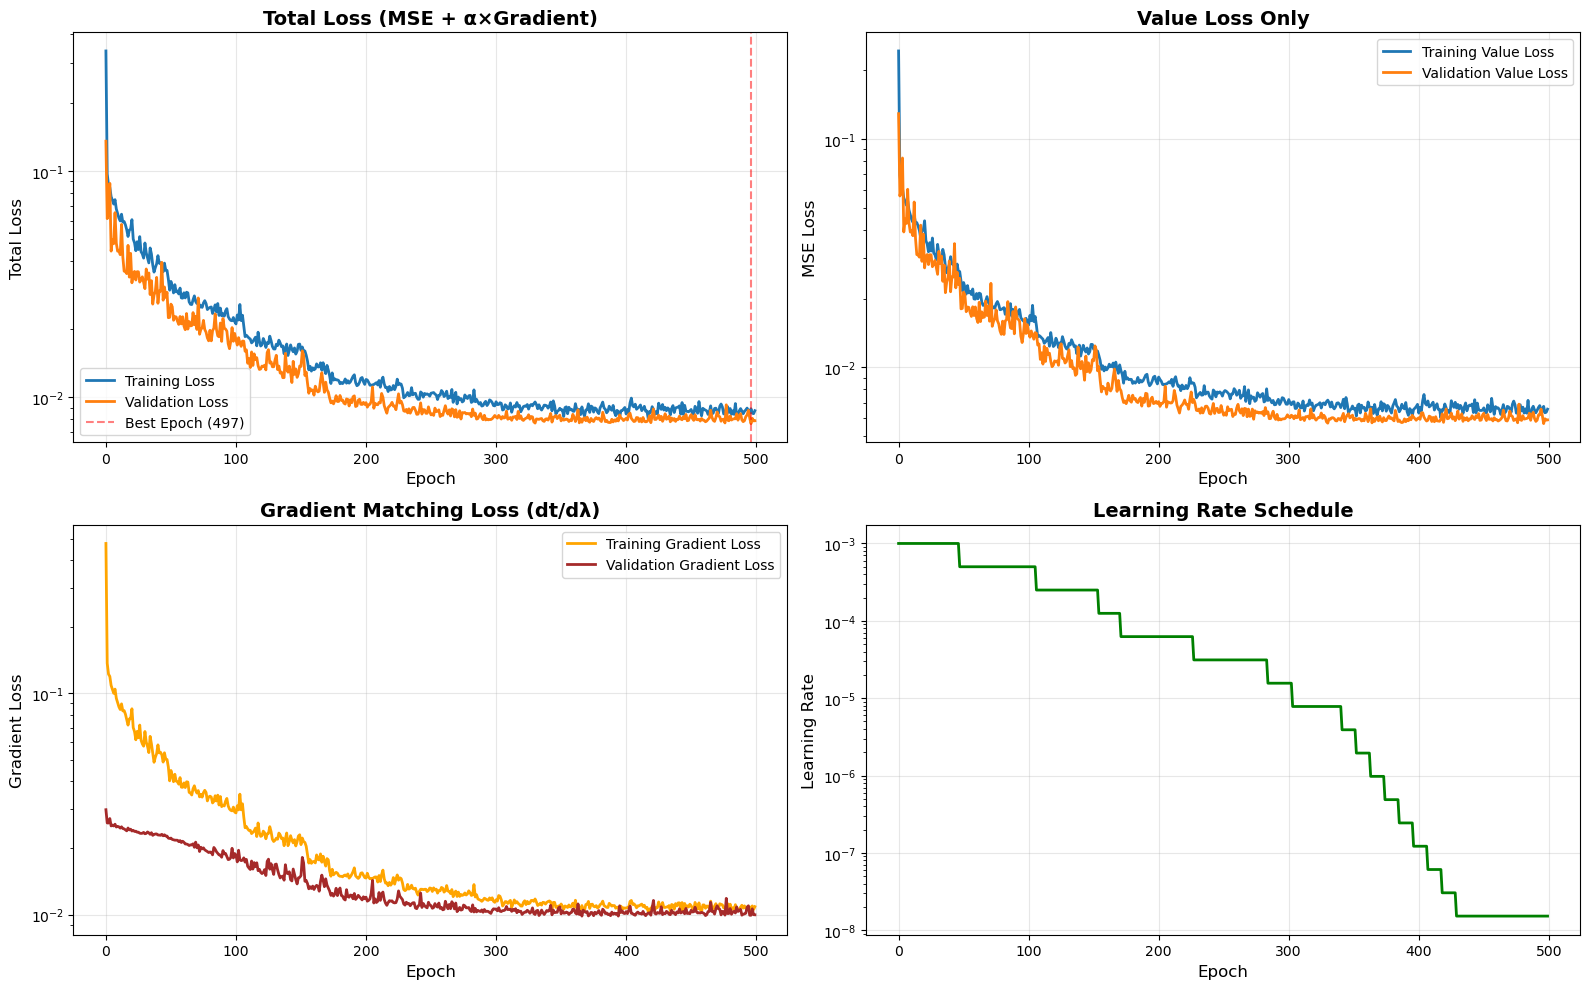

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Total loss
axes[0, 0].plot(history['train_loss'], label='Training Loss', linewidth=2)
axes[0, 0].plot(history['valid_loss'], label='Validation Loss', linewidth=2)
axes[0, 0].axvline(best_epoch, color='red', linestyle='--', alpha=0.5, label=f'Best Epoch ({best_epoch+1})')
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Total Loss', fontsize=12)
axes[0, 0].set_title('Total Loss (MSE + α×Gradient)', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_yscale('log')

# Value loss only
axes[0, 1].plot(history['train_value_loss'], label='Training Value Loss', linewidth=2)
axes[0, 1].plot(history['valid_value_loss'], label='Validation Value Loss', linewidth=2)
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('MSE Loss', fontsize=12)
axes[0, 1].set_title('Value Loss Only', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_yscale('log')

# Gradient loss only
axes[1, 0].plot(history['train_grad_loss'], label='Training Gradient Loss', linewidth=2, color='orange')
axes[1, 0].plot(history['valid_grad_loss'], label='Validation Gradient Loss', linewidth=2, color='brown')
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Gradient Loss', fontsize=12)
axes[1, 0].set_title('Gradient Matching Loss (dt/dλ)', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_yscale('log')

# Learning rate
axes[1, 1].plot(history['lr'], color='green', linewidth=2)
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('Learning Rate', fontsize=12)
axes[1, 1].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_yscale('log')

plt.tight_layout()
plt.show()

## 12. Load Best Model and Evaluate

In [13]:
# Load best model
checkpoint = torch.load('best_surrogate_model.pth', weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"Loaded best model from epoch {checkpoint['epoch']+1}")
print(f"  Training loss: {checkpoint['train_loss']:.6f}")
print(f"  Validation loss: {checkpoint['valid_loss']:.6f}")
print(f"  Gradient weight (α): {checkpoint['alpha']}")

Loaded best model from epoch 497
  Training loss: 0.008905
  Validation loss: 0.007657
  Gradient weight (α): 0.2


## Surrogate Model Predictions

In [14]:
n_glass = 1.5     # Electric field normalization

In [15]:
def predict_spectrum(model, length, width, wavelengths, norm_bounds, device):
    """
    Predict full spectrum for given geometry.
    
    Args:
        model: Trained neural network
        length: Rectangle length [μm]
        width: Rectangle width [μm]
        wavelengths: Array of wavelengths [μm]
        norm_bounds: Normalization bounds dictionary
        device: torch device
    
    Returns:
        Complex array of transmission coefficients
    """
    model.eval()
    
    # Normalize inputs to [-1, 1] using min/max scaling
    length_norm = 2 * (length - norm_bounds['length_min']) / \
                  (norm_bounds['length_max'] - norm_bounds['length_min']) - 1
    width_norm = 2 * (width - norm_bounds['width_min']) / \
                 (norm_bounds['width_max'] - norm_bounds['width_min']) - 1
    wavelengths_norm = 2 * (wavelengths - norm_bounds['wavelength_min']) / \
                       (norm_bounds['wavelength_max'] - norm_bounds['wavelength_min']) - 1
    
    # Create input array: (n_wavelengths, 3)
    inputs = np.zeros((len(wavelengths), 3))
    inputs[:, 0] = length_norm
    inputs[:, 1] = width_norm
    inputs[:, 2] = wavelengths_norm
    
    # Convert to tensor
    inputs_tensor = torch.tensor(inputs, dtype=torch.float32).to(device)
    
    # Predict
    with torch.no_grad():
        outputs = model(inputs_tensor).cpu().numpy()
    
    # Convert to complex
    t_xx_pred = outputs[:, 0] + 1j * outputs[:, 1]
    
    return t_xx_pred

## Training Set

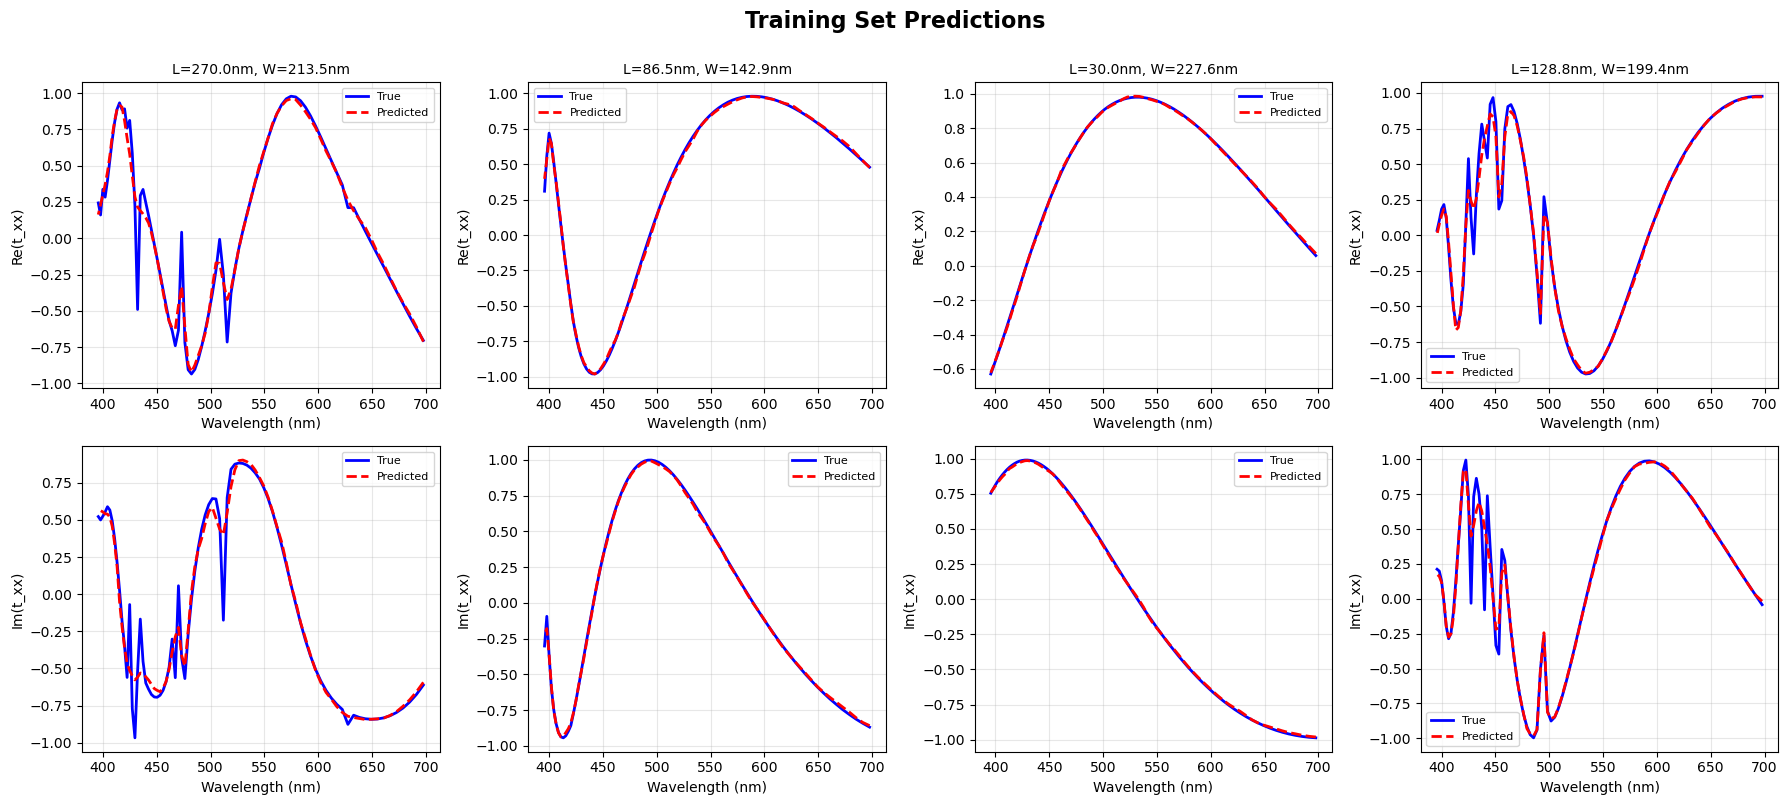

In [19]:
# Select 4 random samples from training set
np.random.seed(123)
train_samples_to_plot = np.random.choice(train_indices, 4, replace=False)

fig, axes = plt.subplots(2, 4, figsize=(18, 8))

for i, sample_idx in enumerate(train_samples_to_plot):
    # Get geometry
    sample_info = metadata.iloc[sample_idx]
    length = sample_info['rect_length_um']
    width = sample_info['rect_width_um']
    
    # Ground truth
    t_xx_true = all_t_xx[sample_idx] / np.sqrt(n_glass)
    
    # Prediction
    t_xx_pred = predict_spectrum(model, length, width, wavelengths, norm_bounds, device) / np.sqrt(n_glass)
    
    # Plot real part
    axes[0, i].plot(wavelengths * 1000, t_xx_true.real, 'b-', linewidth=2, label='True')
    axes[0, i].plot(wavelengths * 1000, t_xx_pred.real, 'r--', linewidth=2, label='Predicted')
    axes[0, i].set_xlabel('Wavelength (nm)', fontsize=10)
    axes[0, i].set_ylabel('Re(t_xx)', fontsize=10)
    axes[0, i].set_title(f'L={length*1000:.1f}nm, W={width*1000:.1f}nm', fontsize=10)
    axes[0, i].legend(fontsize=8)
    axes[0, i].grid(True, alpha=0.3)
    
    # Plot imaginary part
    axes[1, i].plot(wavelengths * 1000, t_xx_true.imag, 'b-', linewidth=2, label='True')
    axes[1, i].plot(wavelengths * 1000, t_xx_pred.imag, 'r--', linewidth=2, label='Predicted')
    axes[1, i].set_xlabel('Wavelength (nm)', fontsize=10)
    axes[1, i].set_ylabel('Im(t_xx)', fontsize=10)
    axes[1, i].legend(fontsize=8)
    axes[1, i].grid(True, alpha=0.3)

fig.suptitle('Training Set Predictions', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## Validation Set

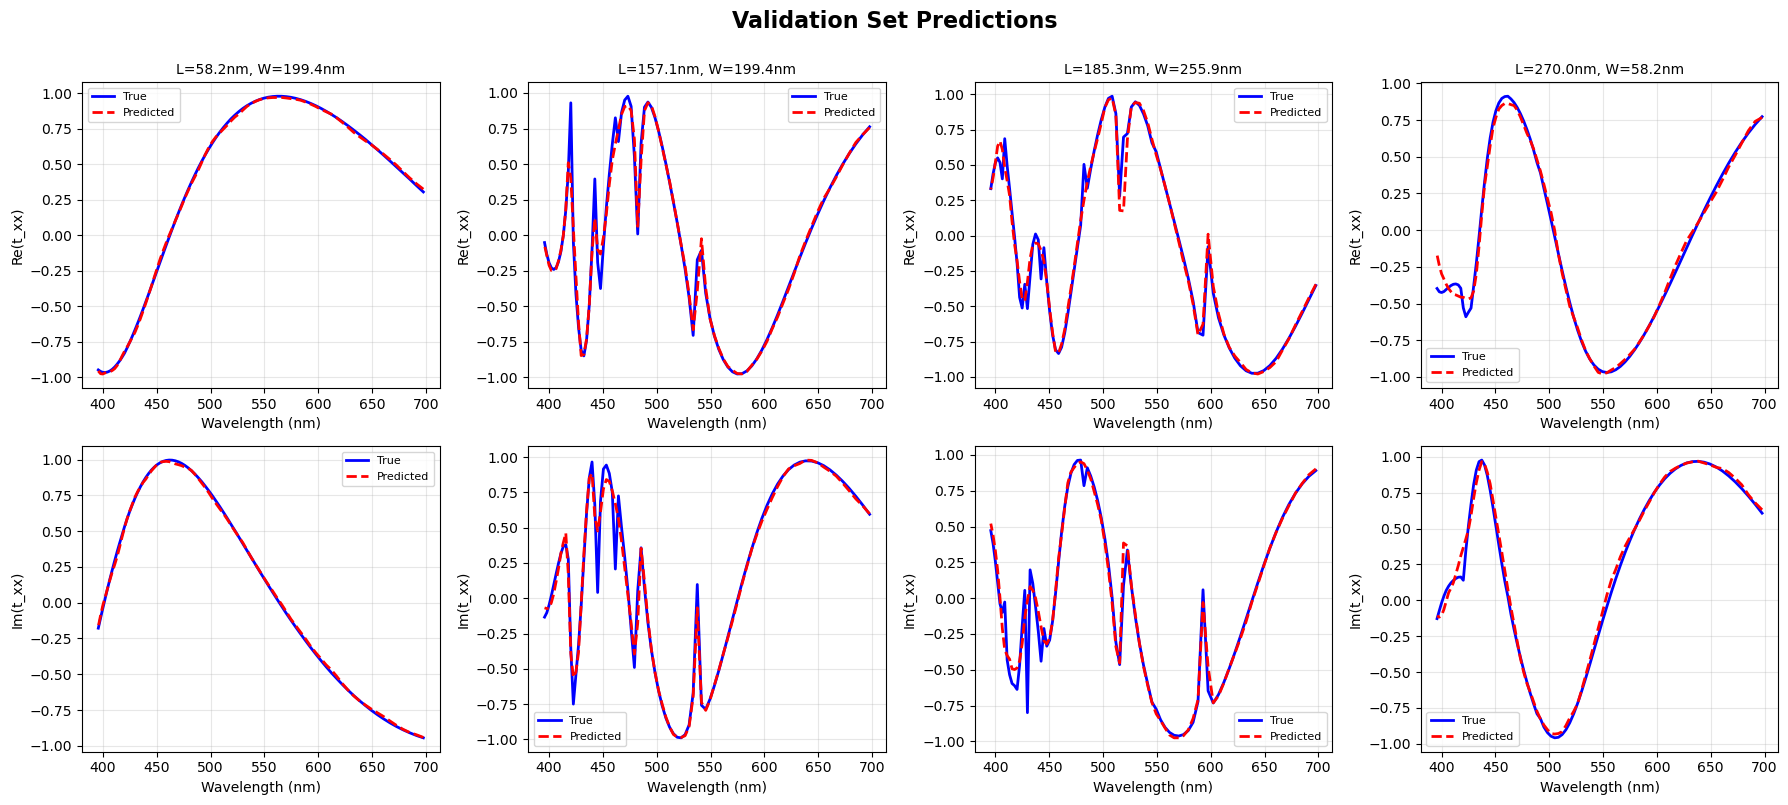

In [20]:
# Select 4 random samples from validation set
np.random.seed(456)
valid_samples_to_plot = np.random.choice(valid_indices, 4, replace=False)

fig, axes = plt.subplots(2, 4, figsize=(18, 8))

for i, sample_idx in enumerate(valid_samples_to_plot):
    # Get geometry
    sample_info = metadata.iloc[sample_idx]
    length = sample_info['rect_length_um']
    width = sample_info['rect_width_um']
    
    # Ground truth
    t_xx_true = all_t_xx[sample_idx] / np.sqrt(n_glass)
    
    # Prediction
    t_xx_pred = predict_spectrum(model, length, width, wavelengths, norm_bounds, device) / np.sqrt(n_glass)
    
    # Plot real part
    axes[0, i].plot(wavelengths * 1000, t_xx_true.real, 'b-', linewidth=2, label='True')
    axes[0, i].plot(wavelengths * 1000, t_xx_pred.real, 'r--', linewidth=2, label='Predicted')
    axes[0, i].set_xlabel('Wavelength (nm)', fontsize=10)
    axes[0, i].set_ylabel('Re(t_xx)', fontsize=10)
    axes[0, i].set_title(f'L={length*1000:.1f}nm, W={width*1000:.1f}nm', fontsize=10)
    axes[0, i].legend(fontsize=8)
    axes[0, i].grid(True, alpha=0.3)
    
    # Plot imaginary part
    axes[1, i].plot(wavelengths * 1000, t_xx_true.imag, 'b-', linewidth=2, label='True')
    axes[1, i].plot(wavelengths * 1000, t_xx_pred.imag, 'r--', linewidth=2, label='Predicted')
    axes[1, i].set_xlabel('Wavelength (nm)', fontsize=10)
    axes[1, i].set_ylabel('Im(t_xx)', fontsize=10)
    axes[1, i].legend(fontsize=8)
    axes[1, i].grid(True, alpha=0.3)

fig.suptitle('Validation Set Predictions', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## Magnitude and Phase

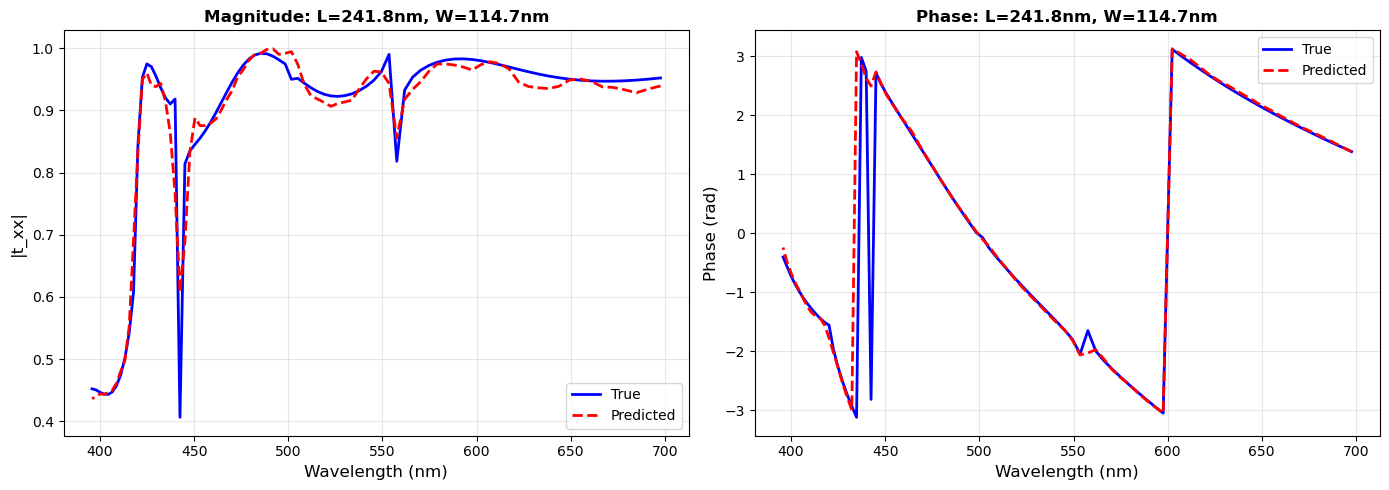

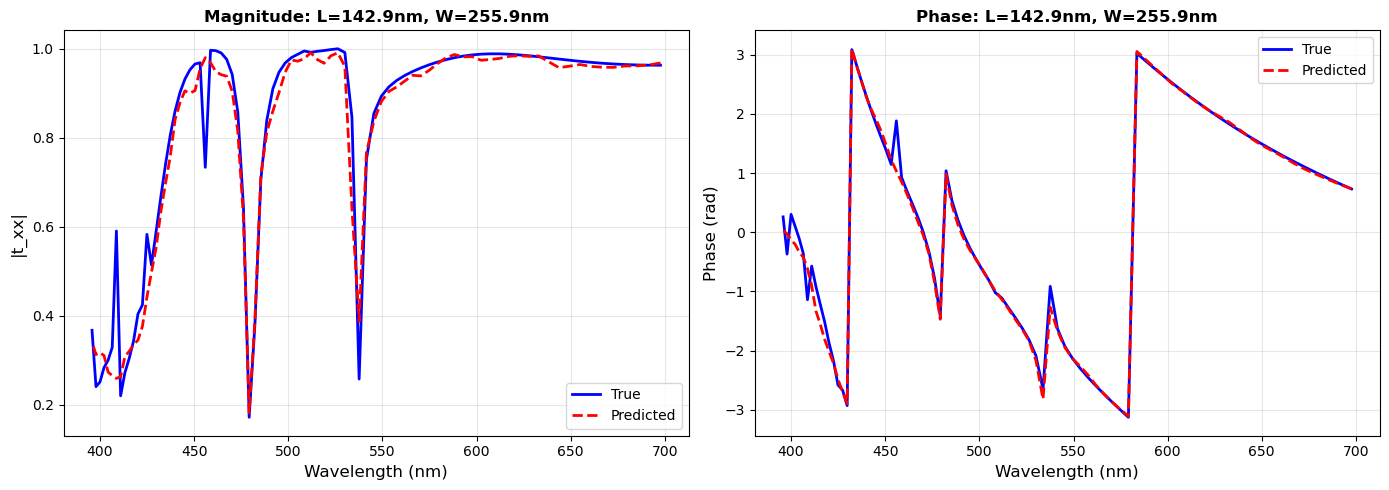

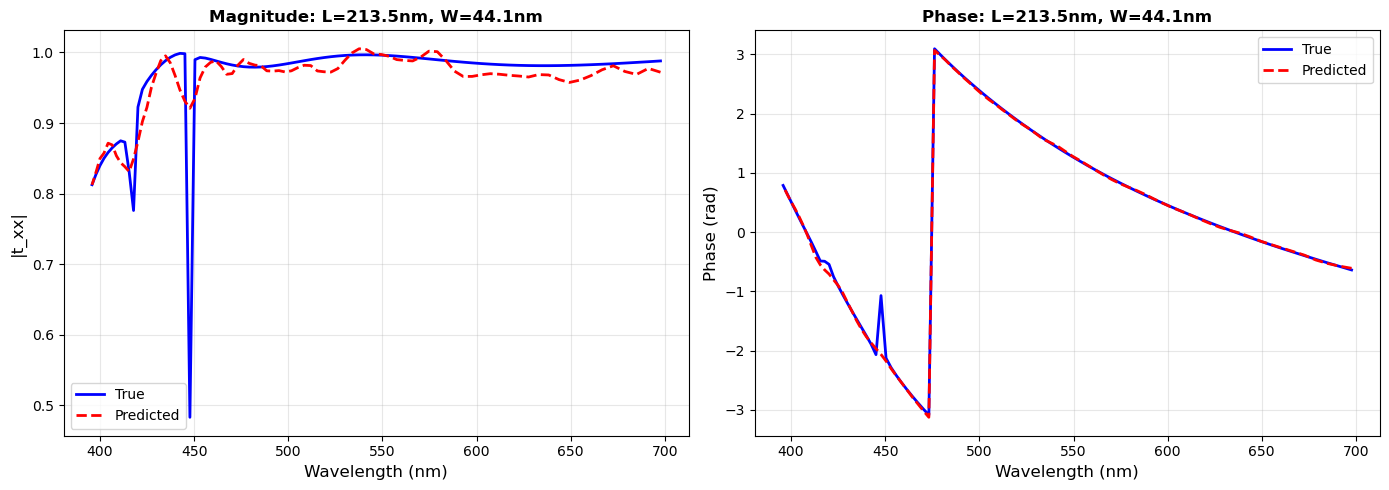

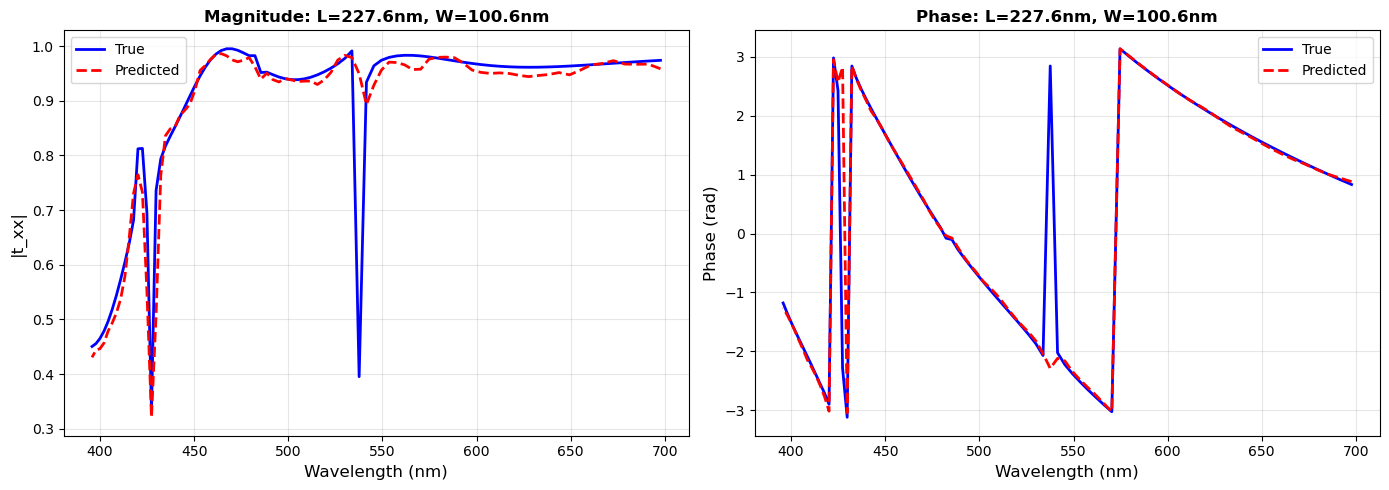

In [18]:
# Select 4 random samples from validation set
np.random.seed(7890)
valid_samples_to_plot = np.random.choice(valid_indices, 4, replace=False)

for sample_idx in valid_samples_to_plot:
    # Geometry
    sample_info = metadata.iloc[sample_idx]
    length = sample_info['rect_length_um']
    width = sample_info['rect_width_um']
    
    # Ground truth and prediction
    t_xx_true = all_t_xx[sample_idx] / np.sqrt(n_glass)
    t_xx_pred = predict_spectrum(model, length, width, wavelengths, norm_bounds, device) / np.sqrt(n_glass)
    
    # Magnitude and phase
    mag_true = np.abs(t_xx_true)
    mag_pred = np.abs(t_xx_pred)
    phase_true = np.angle(t_xx_true)
    phase_pred = np.angle(t_xx_pred)
    
    # Create a NEW figure for each sample
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # ---- Magnitude ----
    axes[0].plot(wavelengths * 1000, mag_true, 'b-', linewidth=2, label='True')
    axes[0].plot(wavelengths * 1000, mag_pred, 'r--', linewidth=2, label='Predicted')
    axes[0].set_xlabel('Wavelength (nm)', fontsize=12)
    axes[0].set_ylabel('|t_xx|', fontsize=12)
    axes[0].set_title(f'Magnitude: L={length*1000:.1f}nm, W={width*1000:.1f}nm',
                      fontsize=12, fontweight='bold')
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)
    
    # ---- Phase ----
    axes[1].plot(wavelengths * 1000, phase_true, 'b-', linewidth=2, label='True')
    axes[1].plot(wavelengths * 1000, phase_pred, 'r--', linewidth=2, label='Predicted')
    axes[1].set_xlabel('Wavelength (nm)', fontsize=12)
    axes[1].set_ylabel('Phase (rad)', fontsize=12)
    axes[1].set_title(f'Phase: L={length*1000:.1f}nm, W={width*1000:.1f}nm',
                      fontsize=12, fontweight='bold')
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()